# Evaluating LSTM vs MLP with Sliding Window for Drought Prediction in the U.S

## I am trying to predict the degree of drought in different seasons and throughout the years. This is a multiclass classification problem with five different classes.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## SOIL DATA

In [19]:
df = pd.read_csv('/Users/aqsa/Desktop/NC-Final/soil_data.csv')

In [20]:
pd.set_option('display.max_columns', None)
df.head(5)

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,0.0000,0.0,0.1033,0.1859,0.2003,0.1898,0.3207,0.9974,27.940498,0.2889,2.750274,10.714703,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,0.0000,0.0,0.1415,0.2379,0.2183,0.1997,0.2026,0.0000,0.000000,0.4146,2.225602,22.952839,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,0.0000,0.0,0.1168,0.1386,0.1048,0.1282,0.5116,0.0000,0.000000,3.5010,4.972456,28.685991,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,0.0000,0.0,0.1971,0.1885,0.2279,0.2104,0.1761,0.0000,0.000000,0.2283,8.674664,89.172112,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,0.0189,0.0,0.2569,0.1503,0.2028,0.2978,0.0922,0.0000,0.000000,1.0037,8.606856,88.470047,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


In [21]:
df.shape

(3109, 32)

In [22]:
df.describe()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000
mean,30678.538437,38.280052,-91.659790,427.624638,0.054973,0.29775,0.319991,0.155878,0.053409,0.065323,0.022223,0.009267,0.143749,0.168888,0.148392,0.165061,0.352723,2.850511,1.801451,2.670026,19.812154,39.296586,28.494804,3.504682,31.999486,1.830492,1.553554,1.282084,1.35735,1.146993,1.135092,1.284979
std,14986.018730,4.838634,11.485291,500.158880,0.089873,0.21595,0.167727,0.128400,0.073107,0.125526,0.064127,0.044933,0.078237,0.084105,0.082111,0.087843,0.272182,13.159247,7.971805,9.770693,25.447435,34.365530,31.839502,10.290893,33.099657,1.192219,1.021382,1.002508,1.03011,0.922308,0.914502,1.017465
min,1001.000000,25.601043,-124.211407,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,19045.000000,34.686818,-98.046842,132.000000,0.008300,0.10510,0.185800,0.040800,0.000500,0.000000,0.000000,0.000000,0.086200,0.109200,0.086300,0.101500,0.115600,0.000000,0.000000,0.104800,4.360057,4.552230,0.143526,0.045909,1.602227,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
50%,29213.000000,38.328061,-90.181170,272.000000,0.028300,0.27100,0.347100,0.127500,0.012200,0.000700,0.000000,0.000000,0.144200,0.174000,0.148300,0.165500,0.305900,0.000000,0.000000,0.488500,8.839095,30.573359,14.043937,0.276606,18.811279,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
75%,46009.000000,41.703590,-83.373303,483.000000,0.068500,0.47750,0.459300,0.255200,0.090300,0.054100,0.001200,0.000000,0.195600,0.227600,0.206600,0.223100,0.555200,0.000000,0.000000,1.115100,23.720787,74.532990,51.737080,1.370315,60.637421,3.000000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,56045.000000,48.842653,-67.609354,3561.000000,0.974000,0.75990,0.696900,0.571700,0.330000,0.606800,0.476500,0.628800,0.478400,0.738500,0.511200,0.657800,1.000000,100.000000,99.982918,99.998764,99.998596,91.044609,97.029572,99.956841,99.956841,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000


## TRAINING + TEST + VALIDATION DATA

In [23]:
train= pd.read_csv('/Users/aqsa/Desktop/NC-Final/train_timeseries.csv')

test= pd.read_csv('/Users/aqsa/Desktop/NC-Final/test_timeseries.csv')

validation = pd.read_csv('/Users/aqsa/Desktop/NC-Final/validation_timeseries.csv')

data=train.copy()

In [24]:
data.head(10)

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,9.50,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,10.18,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,7.41,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,13.48,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN
5,1001,2000-01-06,0.01,101.31,3.49,4.99,-1.11,-1.07,12.89,-2.96,15.85,3.32,1.55,2.39,0.04,2.35,2.95,5.22,0.05,5.17,NaN
6,1001,2000-01-07,0.01,101.37,3.93,5.99,0.55,0.58,14.51,0.63,13.88,5.69,2.31,3.28,1.59,1.69,5.02,6.47,2.44,4.03,NaN
7,1001,2000-01-08,1.02,100.77,5.71,8.69,5.33,5.34,15.78,2.74,13.04,8.75,2.05,2.91,1.50,1.40,4.17,5.73,2.01,3.72,NaN
8,1001,2000-01-09,16.19,99.88,11.18,15.73,15.45,15.45,19.60,10.30,9.31,15.65,3.03,3.98,2.25,1.73,5.97,7.44,4.95,2.49,NaN
9,1001,2000-01-10,21.23,99.78,7.77,13.61,9.59,9.60,17.65,7.73,9.92,13.42,3.10,5.60,1.72,3.88,6.33,10.03,4.15,5.88,NaN


In [25]:
test.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2019-01-01,2.25,100.51,9.69,14.71,13.55,13.52,17.38,10.92,6.46,14.63,1.20,1.50,0.79,0.71,2.74,4.01,1.23,2.78,0.0
1,1001,2019-01-02,4.94,100.48,8.65,13.05,11.83,11.74,17.76,9.54,8.23,13.06,1.02,1.35,0.32,1.03,2.13,3.37,0.56,2.81,NaN
2,1001,2019-01-03,20.74,100.03,8.59,12.12,11.67,11.67,13.74,10.44,3.30,12.12,1.83,4.23,0.34,3.88,3.41,7.49,0.72,6.77,NaN
3,1001,2019-01-04,16.17,99.47,7.93,11.80,10.38,9.59,18.19,5.44,12.75,11.72,3.75,5.25,2.34,2.91,6.78,9.61,4.90,4.71,NaN
4,1001,2019-01-05,0.01,100.39,5.32,7.91,4.73,4.71,14.37,3.68,10.69,7.75,2.32,2.90,1.69,1.21,4.42,5.87,3.15,2.72,NaN


In [26]:
validation.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2017-01-01,32.50,100.02,10.47,14.69,14.47,14.47,17.68,10.53,7.15,14.63,2.14,2.71,1.52,1.19,4.40,5.96,2.25,3.71,NaN
1,1001,2017-01-02,63.52,100.04,12.75,17.96,17.75,17.75,20.30,16.14,4.16,17.85,2.75,4.31,1.60,2.71,5.50,8.16,4.05,4.11,NaN
2,1001,2017-01-03,18.82,99.69,9.74,14.24,13.44,13.44,18.48,9.29,9.20,14.06,2.25,3.73,1.64,2.09,4.80,7.27,2.54,4.72,2.0
3,1001,2017-01-04,0.01,100.02,5.21,8.10,3.86,3.88,11.74,2.12,9.62,8.08,2.63,3.95,1.34,2.60,4.98,6.16,3.36,2.80,NaN
4,1001,2017-01-05,0.01,99.89,4.54,5.91,2.20,2.22,13.07,-0.18,13.24,5.85,1.76,2.76,0.47,2.28,3.43,4.70,0.66,4.04,NaN


In [27]:
data['rolling_avg_temp'] = data['T2M'].rolling(window=3).mean()
data['lagged_temp'] = data['T2M'].shift(1)
data['rolling_sum_precip'] = data['PRECTOT'].rolling(window=3).sum()

In [28]:
#import sweetviz as sv
#report = sv.analyze(data)
#report.show_html('eda_report.html')

In [29]:
data['score'].value_counts()

score
0.0000    1480827
1.0000     219135
2.0000     123789
3.0000      82801
4.0000      45841
           ...   
0.7347          1
1.4432          1
2.4372          1
2.6447          1
0.6060          1
Name: count, Length: 57489, dtype: int64

In [30]:
validation['score'].value_counts()

score
0.0000    191773
1.0000     20325
2.0000      8666
3.0000      3335
4.0000      1194
           ...  
3.4620         1
3.4611         1
2.2181         1
3.1041         1
2.9764         1
Name: count, Length: 25352, dtype: int64

In [31]:
test['score'].value_counts()

score
0.0000    222634
1.0000     12196
2.0000      5585
3.0000      1875
4.0000       781
           ...  
3.1413         1
2.7347         1
2.7332         1
0.5511         1
1.1645         1
Name: count, Length: 24518, dtype: int64

In [32]:
data.isnull().sum()

fips                         0
date                         0
PRECTOT                      0
PS                           0
QV2M                         0
T2M                          0
T2MDEW                       0
T2MWET                       0
T2M_MAX                      0
T2M_MIN                      0
T2M_RANGE                    0
TS                           0
WS10M                        0
WS10M_MAX                    0
WS10M_MIN                    0
WS10M_RANGE                  0
WS50M                        0
WS50M_MAX                    0
WS50M_MIN                    0
WS50M_RANGE                  0
score                 16543884
rolling_avg_temp             2
lagged_temp                  1
rolling_sum_precip           2
dtype: int64

In [16]:
validation.isnull().sum()

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [17]:
test.isnull().sum()

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [18]:
data.shape

(19300680, 24)

In [19]:
data.dropna(inplace=True)

In [20]:
validation.dropna(inplace=True)

In [21]:
test.dropna(inplace=True)

In [22]:
data.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score                 0
rolling_avg_temp      0
lagged_temp           0
rolling_sum_precip    0
dtype: int64

In [23]:
validation.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

In [24]:
test.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

In [25]:
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['score'] = data['score'].round().astype(int)
data.dtypes

fips                    int64
date                   object
PRECTOT               float64
PS                    float64
QV2M                  float64
T2M                   float64
T2MDEW                float64
T2MWET                float64
T2M_MAX               float64
T2M_MIN               float64
T2M_RANGE             float64
TS                    float64
WS10M                 float64
WS10M_MAX             float64
WS10M_MIN             float64
WS10M_RANGE           float64
WS50M                 float64
WS50M_MAX             float64
WS50M_MIN             float64
WS50M_RANGE           float64
score                   int64
rolling_avg_temp      float64
lagged_temp           float64
rolling_sum_precip    float64
year                    int32
month                   int32
day                     int32
dtype: object

In [26]:
validation['year'] = pd.DatetimeIndex(validation['date']).year
validation['month'] = pd.DatetimeIndex(validation['date']).month
validation['day'] = pd.DatetimeIndex(validation['date']).day
validation['score'] = validation['score'].round().astype(int)
validation.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

In [27]:
test['year'] = pd.DatetimeIndex(test['date']).year
test['month'] = pd.DatetimeIndex(test['date']).month
test['day'] = pd.DatetimeIndex(test['date']).day
test['score'] = test['score'].round().astype(int)
test.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

In [28]:
data.isnull().any().any()

False

In [29]:
data.score.value_counts()

score
0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

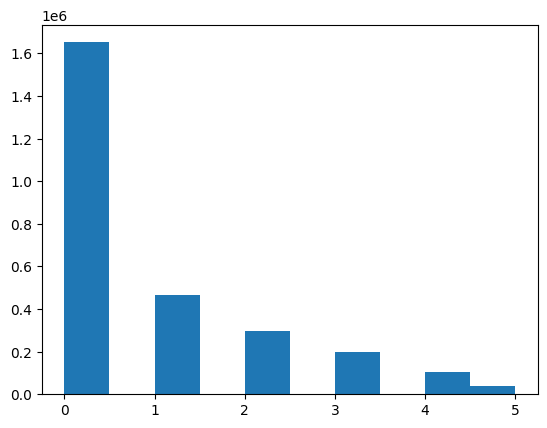

In [30]:
plt.hist(data['score'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

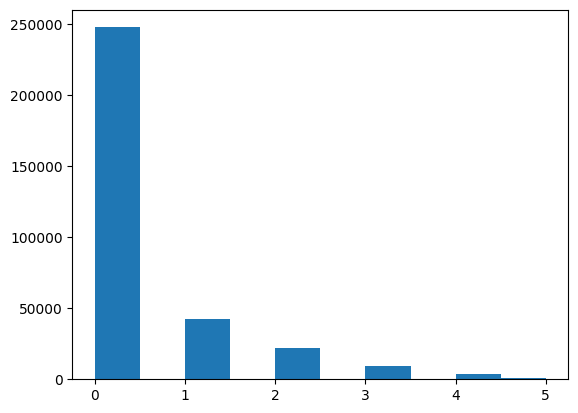

In [31]:
plt.hist(test['score'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

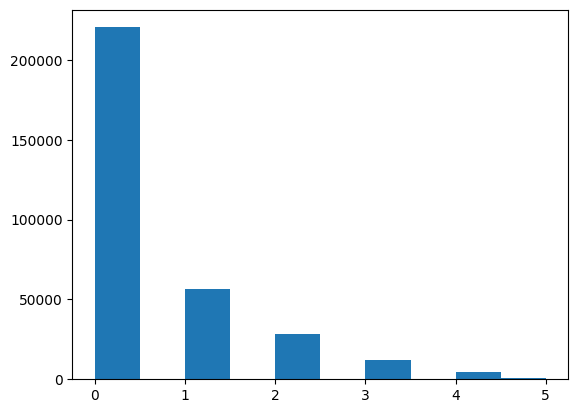

In [32]:
plt.hist(validation['score'])
plt.show

Data is not evenly distributed, i will check for duplicates now

In [33]:
data.duplicated().any()

False

# EDA

In [34]:
# For numeric columns
display(data.describe().T)

# For Categorical columns
display(data.describe(include=['object']))

,count,mean,std,min,25%,50%,75%,max
fips,2756796.0,30670.376770,14979.110105,1001.000000,19044.500000,29212.000000,46007.50,56043.00
PRECTOT,2756796.0,2.714566,6.247590,0.000000,0.000000,0.190000,2.26,168.69
PS,2756796.0,96.647365,5.444698,66.490000,95.830000,98.280000,99.94,103.76
QV2M,2756796.0,7.875770,4.721459,0.140000,3.810000,6.940000,11.45,22.12
T2M,2756796.0,12.899230,10.970402,-35.440000,4.580000,14.210000,22.00,39.33
T2MDEW,2756796.0,7.049350,10.197650,-35.440000,-0.880000,7.810000,15.67,26.87
T2MWET,2756796.0,7.084938,10.143641,-35.460000,-0.840000,7.810000,15.67,26.87
T2M_MAX,2756796.0,18.767110,11.602952,-30.030000,10.360000,20.620000,27.97,47.75
T2M_MIN,2756796.0,7.519916,10.618183,-40.850000,-0.570000,8.260000,16.28,32.28
T2M_RANGE,2756796.0,11.247201,4.038022,0.160000,8.370000,11.200000,14.08,30.17


,date
count,2756796
unique,887
top,2000-01-04
freq,3108


In [35]:
#Get numeric features out into a list and remove unnecessary features
measures_list = [x for x in data.select_dtypes(include=["int64", "float64", "int32"])]
remove_list = ["fips", "score", "year", "month", "day"]

# List comprehension for applying remove_list to our measures_list
measures_list = [i for i in measures_list if i not in remove_list]
# Create measures_df out of df with only the numeric features we want to visualize
measures_df = data[measures_list]

In [36]:
#Get numeric features out into a list and remove unnecessary features
measures_list2 = [x for x in test.select_dtypes(include=["int64", "float64", "int32"])]
remove_list = ["fips", "score", "year", "month", "day"]

# List comprehension for applying remove_list to our measures_list
measures_list2 = [i for i in measures_list2 if i not in remove_list]
# Create measures_df out of df with only the numeric features we want to visualize
measures_df2 = test[measures_list2]

In [37]:
#Get numeric features out into a list and remove unnecessary features
measures_list3 = [x for x in validation.select_dtypes(include=["int64", "float64", "int32"])]
remove_list = ["fips", "score", "year", "month", "day"]

# List comprehension for applying remove_list to our measures_list
measures_list3 = [i for i in measures_list3 if i not in remove_list]
# Create measures_df out of df with only the numeric features we want to visualize
measures_df3 = test[measures_list3]

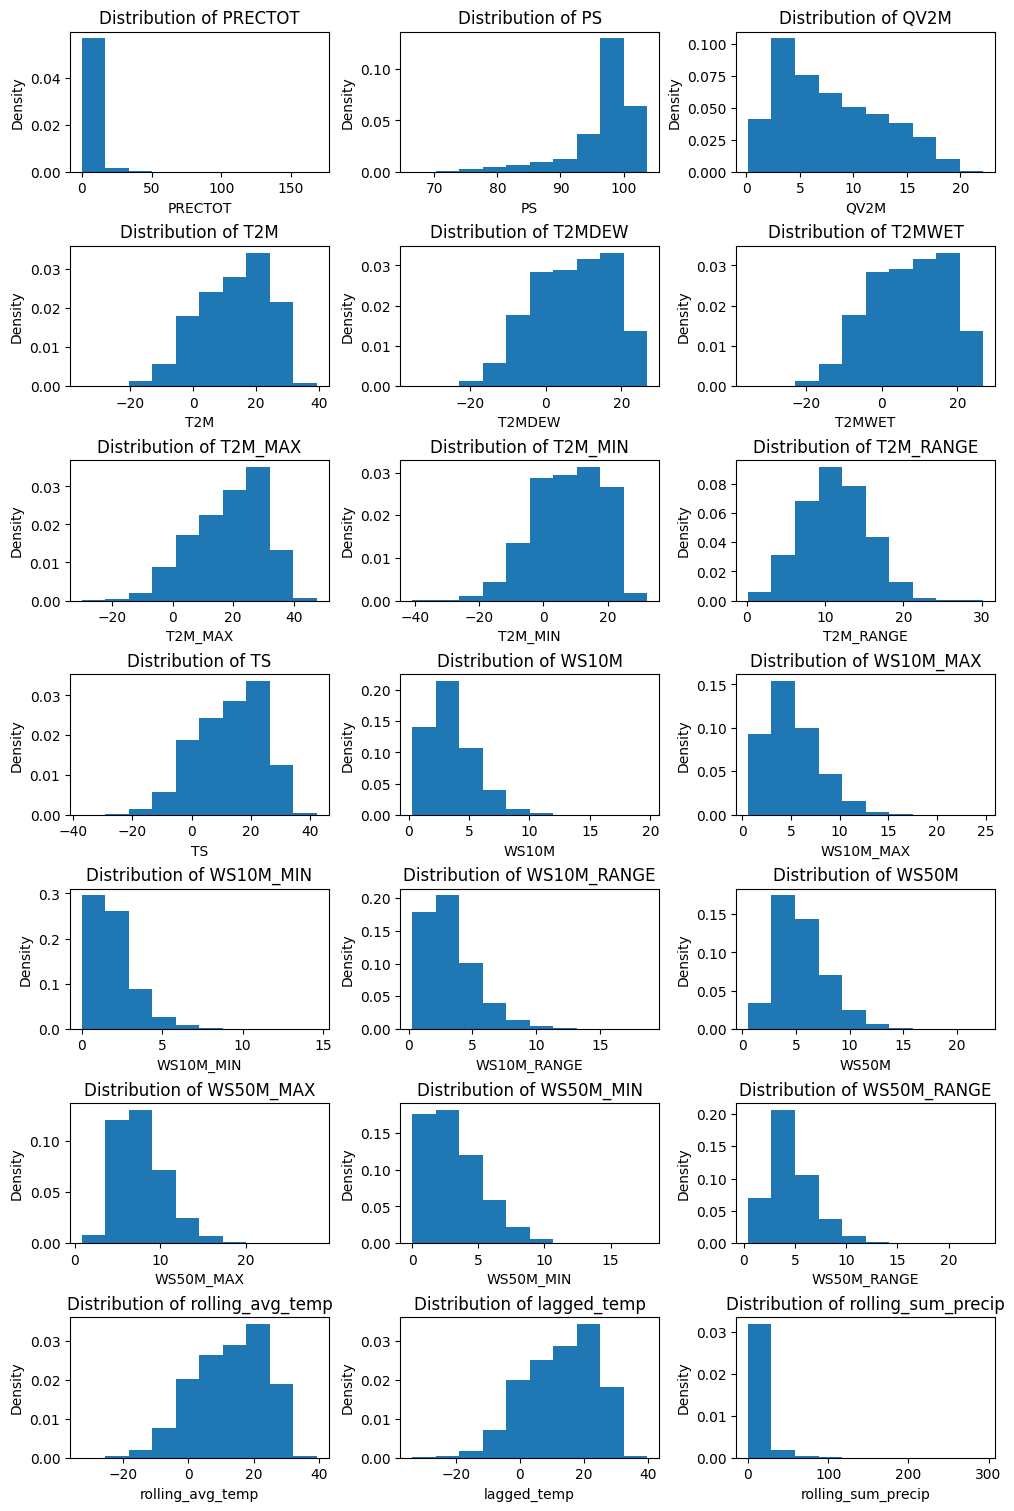

In [38]:
num_cols = 3  # Number of histograms per figure
num_rows = (len(measures_list) + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, col_name in enumerate(measures_list):
    ax = axes[i]
    ax.hist(measures_df[col_name], density=True)
    ax.set_xlabel(col_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {col_name}')

# Turn off axes for any unused subplots
for j in range(len(measures_list), len(axes)):
    axes[j].axis('off')

plt.show()

I can  conclude that the majority of our numeric measurement are normally distributed with a few right or left skewed distributions 

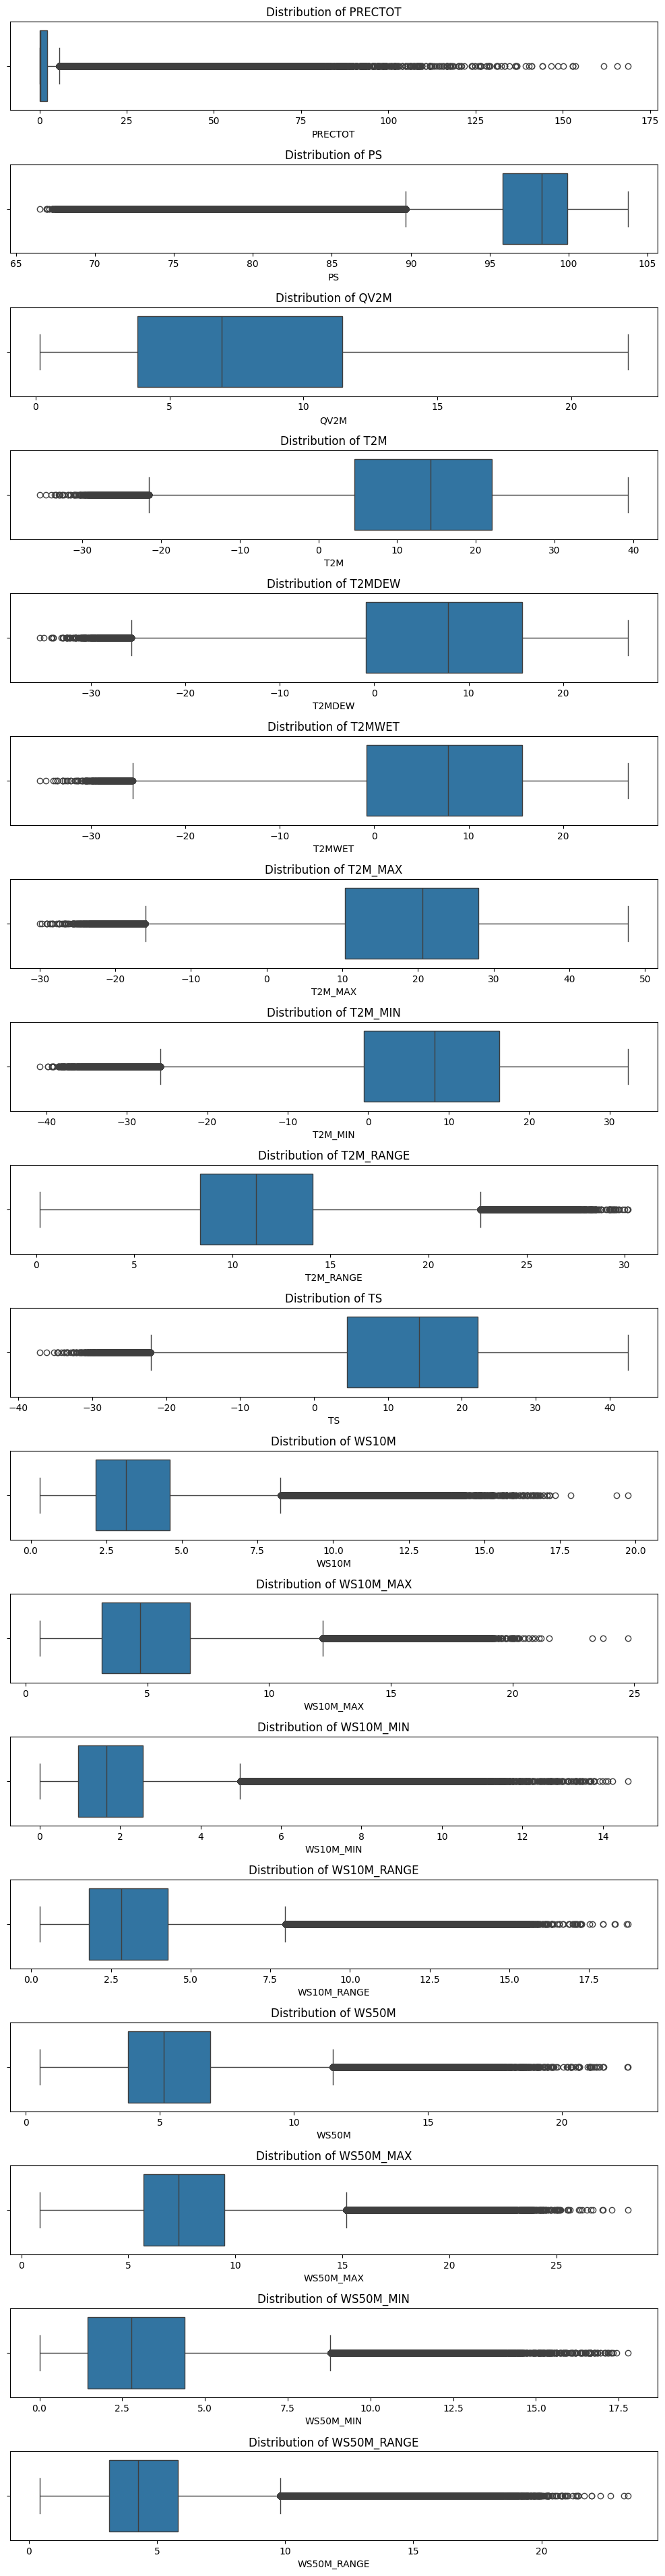

In [39]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  measures_df.columns[x-1], data=measures_df)
    x_name = measures_df.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

Due to the extreme number of outliers in this dataset i will apply a winsorizer

In [ ]:
pip install feature-engine

In [40]:
from feature_engine.outliers import Winsorizer

In [41]:
outlier = Winsorizer(capping_method="gaussian",
                     tail="both",
                    fold=3,
                    variables = measures_list,
                    missing_values="ignore")

outlier.fit(data)


Winsorizer(fold=3, missing_values='ignore', tail='both',
           variables=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
                      'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M',
                      'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
                      'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
                      'rolling_avg_temp', 'lagged_temp', 'rolling_sum_precip'])

In [42]:
# What are our new min and max values?
outlier.right_tail_caps_

{'PRECTOT': 21.457332889766377,
 'PS': 112.98145673263866,
 'QV2M': 22.040143267563096,
 'T2M': 45.810430838854266,
 'T2MDEW': 37.64229397342918,
 'T2MWET': 37.51585439874806,
 'T2M_MAX': 53.57596019370976,
 'T2M_MIN': 39.37446038075016,
 'T2M_RANGE': 23.36126392532109,
 'TS': 46.547769510498355,
 'WS10M': 9.107009452410844,
 'WS10M_MAX': 13.03057234029162,
 'WS10M_MIN': 5.9480289927754,
 'WS10M_RANGE': 9.111675981753821,
 'WS50M': 12.428446678613675,
 'WS50M_MAX': 16.33865015585169,
 'WS50M_MIN': 9.45141107989469,
 'WS50M_RANGE': 11.250282583318262,
 'rolling_avg_temp': 45.05605562436448,
 'lagged_temp': 45.672777451451275,
 'rolling_sum_precip': 46.127710459084454}

In [43]:
outlier.left_tail_caps_

{'PRECTOT': -16.028199932521808,
 'PS': 80.3132728592499,
 'QV2M': -6.288604198295725,
 'T2M': -20.01197101085102,
 'T2MDEW': -23.543593358657553,
 'T2MWET': -23.34597815110406,
 'T2M_MAX': -16.041739656535427,
 'T2M_MIN': -24.334627836013446,
 'T2M_RANGE': -0.8668619673960123,
 'TS': -20.597914229222567,
 'WS10M': -1.9788585555000835,
 'WS10M_MAX': -2.624737719231523,
 'WS10M_MIN': -2.106718696329814,
 'WS10M_RANGE': -2.54714082572487,
 'WS50M': -1.3628487526155277,
 'WS50M_MAX': -0.681052364792798,
 'WS50M_MIN': -3.2082557285375346,
 'WS50M_RANGE': -1.8358359213236906,
 'rolling_avg_temp': -19.398603899003895,
 'lagged_temp': -20.018841447481442,
 'rolling_sum_precip': -30.257689463694064}

In [44]:
# Apply the Winsorizer to my main DataFrame
data = outlier.transform(data)

In [45]:
outlier2 = Winsorizer(capping_method="gaussian",
                     tail="both",
                    fold=3,
                    variables = measures_list2,
                    missing_values="ignore")

outlier2.fit(test)


Winsorizer(fold=3, missing_values='ignore', tail='both',
           variables=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
                      'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M',
                      'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
                      'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'])

In [46]:
test = outlier2.transform(test)

In [47]:
outlier3 = Winsorizer(capping_method="gaussian",
                     tail="both",
                    fold=3,
                    variables = measures_list3,
                    missing_values="ignore")

outlier3.fit(validation)


Winsorizer(fold=3, missing_values='ignore', tail='both',
           variables=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
                      'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M',
                      'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
                      'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'])

In [48]:
validation = outlier3.transform(validation)

<Figure size 1000x4000 with 0 Axes>

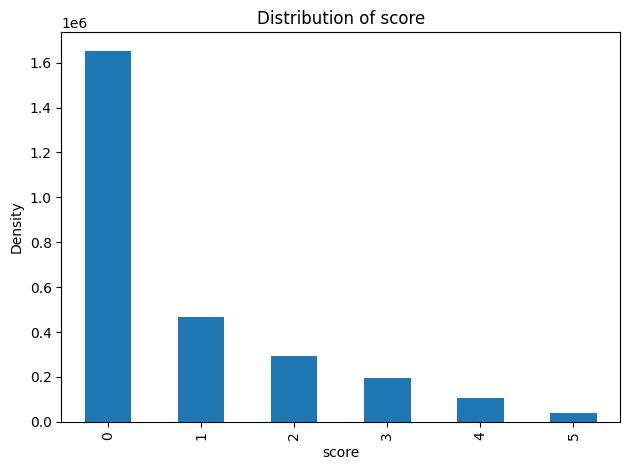

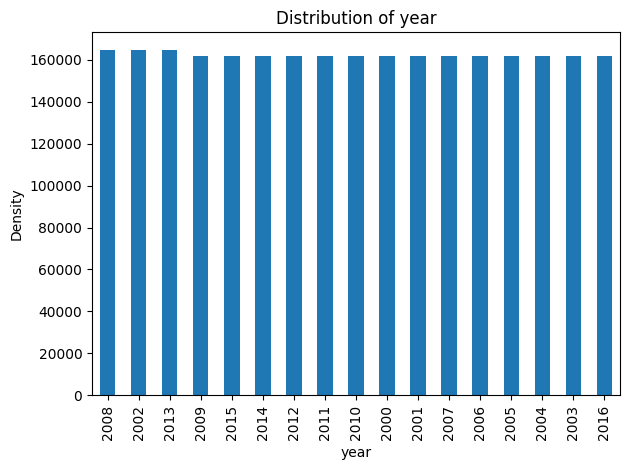

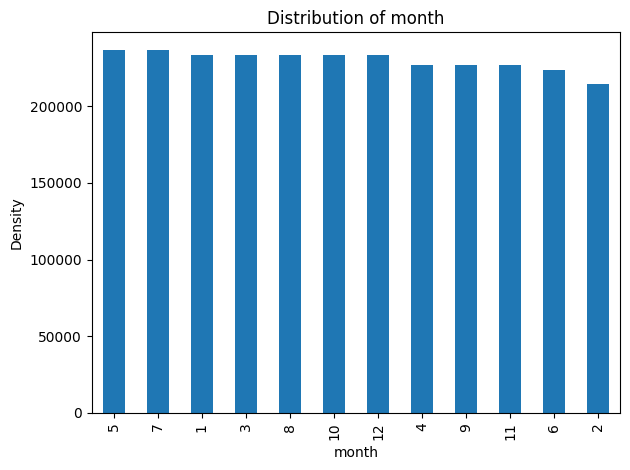

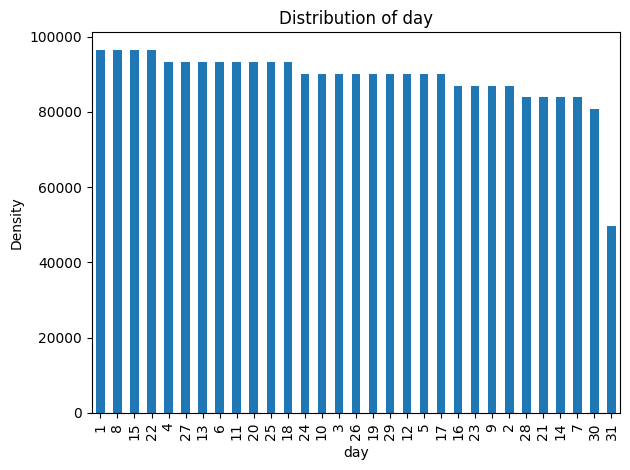

In [49]:
categorical_column_list = ['score','year','month','day']
df_categorical = data[['score','year','month','day']]

plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

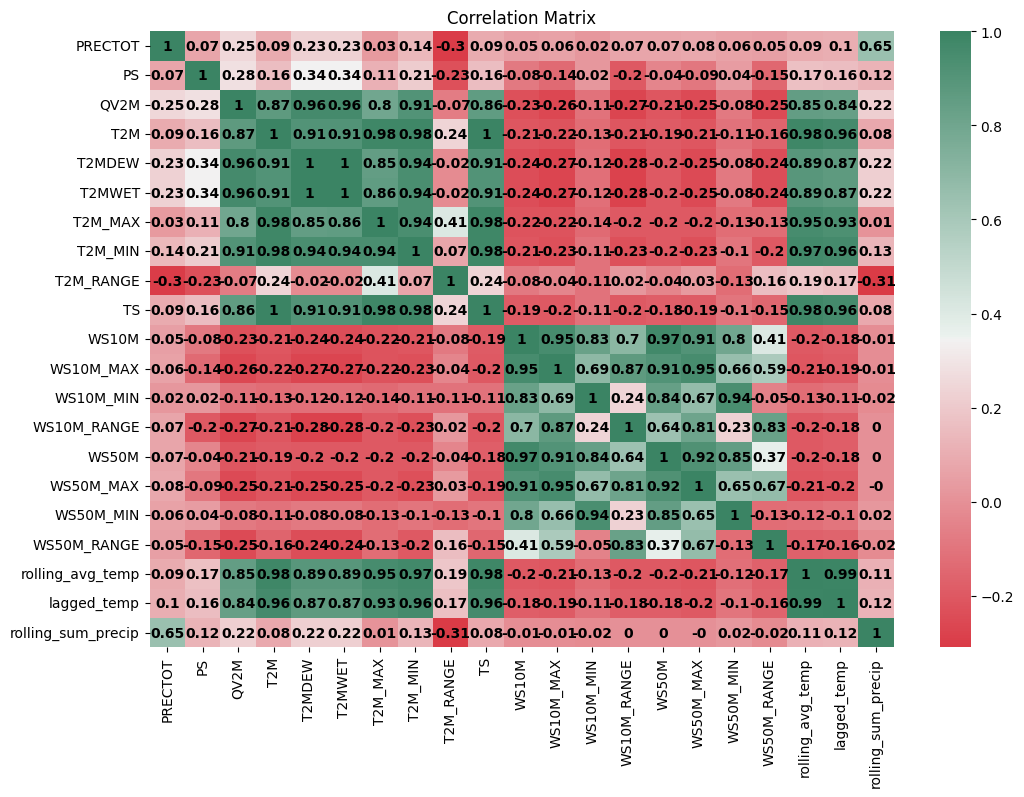

In [50]:
correlation_matrix = measures_df.corr().round(2)

plt.figure(figsize=(12,8))
sns.heatmap(data=correlation_matrix, annot=True, annot_kws={"size": 10, "weight": "bold", "color": "black"}, cmap=sns.diverging_palette(10, 150, as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

## Standardizing all the datasets- after splitting to avoid data leakage and using the training data

In [51]:
from sklearn.preprocessing import StandardScaler

# Select only numerical columns (exclude categorical ones like 'fips', 'date', 'year', 'month', 'day', 'score')
features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 
            'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 
            'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training set
scaler.fit(data[features])

# Transform train, validation, and test sets using the trained scaler
data[features] = scaler.transform(data[features])
validation[features] = scaler.transform(validation[features])
test[features] = scaler.transform(test[features])


## applying SMOTE to ONLY the training dataset

In [52]:
from imblearn.over_sampling import SMOTE

target = 'score'  

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(data[features], data[target])


train_resampled = pd.DataFrame(X_train_resampled, columns=features)
train_resampled[target] = y_train_resampled

In [53]:
data.head(5)

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,rolling_avg_temp,lagged_temp,rolling_sum_precip,year,month,day
3,1001,2000-01-04,2.789071,0.699045,-0.308331,-0.137219,-0.094280,-0.097283,-0.058640,-0.506847,1.159236,-0.149382,0.160085,0.186031,0.136856,0.173155,0.534000,0.537361,0.300867,0.424178,1,15.526667,18.49,19.80,2000,1,4
10,1001,2000-01-11,-0.233425,0.720769,-0.263853,-0.129917,0.077415,0.074330,0.009498,-0.170720,0.474780,-0.228121,-0.994148,-1.054949,-0.667540,-0.976855,-0.872130,-0.515052,-0.674241,-0.008123,2,13.606667,13.61,38.75,2000,1,11
17,1001,2000-01-18,-0.278908,0.718794,0.350364,0.125633,0.609176,0.608894,-0.062952,0.137082,-0.541984,0.108309,-0.511368,-0.619244,-0.183340,-0.715973,-0.146956,-0.507868,0.348902,-1.015242,2,12.456667,14.00,4.05,2000,1,18
24,1001,2000-01-25,-0.508386,0.663498,-1.233892,-1.248862,-1.469795,-1.460324,-1.131594,-1.226310,-0.033602,-1.215937,-0.111825,-0.234113,0.293050,-0.503008,0.100665,0.077604,0.406544,-0.293157,2,3.740000,2.38,14.38,2000,1,25
31,1001,2000-02-01,-0.508386,0.839262,-0.956435,-0.989661,-0.861507,-0.866583,-0.668430,-1.108288,0.988122,-0.993142,-0.844319,-0.953803,-0.800305,-0.747918,-0.593557,-0.515052,-0.885594,0.200902,1,1.370000,-0.27,0.87,2000,2,1


In [2]:

# Define features and target
features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 
            'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 
            'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']
target = 'score'
window_size = 10


In [3]:
def create_sequences(data, target_col, window_size, features):
    data_values = data[features].values
    target_values = data[target_col].values
    num_sequences = len(data) - window_size
    X = np.zeros((num_sequences, window_size, len(features)))
    y = np.zeros(num_sequences)
    for i in range(num_sequences):
        X[i] = data_values[i:i+window_size]
        y[i] = target_values[i + window_size]
    return X, y

In [4]:
X_train, y_train = create_sequences(train_resampled, target, window_size, features)
X_val, y_val = create_sequences(validation, target, window_size, features)
X_test, y_test = create_sequences(test, target, window_size, features)


NameError: name 'train_resampled' is not defined

In [5]:
# Convert to PyTorch tensors for LSTM
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

NameError: name 'torch' is not defined

In [58]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [1]:
# Train LSTM
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = len(np.unique(y_train))
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

num_epochs = 20
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lstm_model.eval()
    val_loss = sum(criterion(lstm_model(X_v), y_v).item() for X_v, y_v in val_loader)
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


NameError: name 'features' is not defined

In [ ]:
# Evaluate LSTM
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
lstm_model.eval()
y_pred_lstm = torch.argmax(lstm_model(X_test_tensor), axis=1).numpy()
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))

# Train MLP with Hyperparameter Tuning
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_val_mlp = X_val.reshape(X_val.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)
param_grid = {'hidden_layer_sizes': [(128, 64), (256, 128), (128,)], 'activation': ['relu', 'tanh'], 'solver': ['adam'], 'max_iter': [200]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(MLPClassifier(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_mlp, y_train)
best_mlp = grid_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_mlp)
print("\nMLP Classification Report:\n", classification_report(y_test, y_pred_mlp))


In [ ]:
# Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training & Validation Loss")
plt.legend()
plt.show()

# Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_lstm, "LSTM Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_mlp, "MLP Confusion Matrix")


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Fix random seeds
torch.manual_seed(42)
np.random.seed(42)


# Define Features & Target
features = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN',
            'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
            'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']
target = "score"
window_size = 10



# Create Sliding Window Sequences
def create_sequences(data, target_col, window_size, features):
    data_values = data[features].values
    target_values = data[target_col].values
    num_sequences = len(data) - window_size
    X = np.zeros((num_sequences, window_size, len(features)))
    y = np.zeros(num_sequences)
    for i in range(num_sequences):
        X[i] = data_values[i:i+window_size]
        y[i] = target_values[i + window_size]
    return X, y

X_train, y_train = create_sequences(train_resampled, target, window_size, features)
X_val, y_val = create_sequences(validation, target, window_size, features)
X_test, y_test = create_sequences(test, target, window_size, features)

# Convert to PyTorch tensors for LSTM
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Hyperparameter Grid for LSTM
lstm_params = {
    'hidden_size': [32, 64],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.5],
    'learning_rate': [0.001, 0.0005]
}

best_lstm_acc = 0
best_lstm_model = None
for hidden_size in lstm_params['hidden_size']:
    for num_layers in lstm_params['num_layers']:
        for dropout in lstm_params['dropout']:
            for learning_rate in lstm_params['learning_rate']:
                
                model = LSTMModel(len(features), hidden_size, num_layers, dropout, len(np.unique(y_train)))
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                
                train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=32)
                
                for epoch in range(10):  # Shorter training for hyperparameter tuning
                    model.train()
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step()
                
                # Evaluate
                model.eval()
                y_pred_val = torch.argmax(model(X_val_tensor), axis=1).numpy()
                acc = accuracy_score(y_val, y_pred_val)
                
                print(f"Hidden: {hidden_size}, Layers: {num_layers}, Dropout: {dropout}, LR: {learning_rate} -> Val Acc: {acc:.4f}")
                
                if acc > best_lstm_acc:
                    best_lstm_acc = acc
                    best_lstm_model = model

# Train Best LSTM Model
lstm_model = best_lstm_model
num_epochs = 20
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    lstm_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lstm_model.eval()
    val_loss = sum(criterion(lstm_model(X_v), y_v).item() for X_v, y_v in val_loader)
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Evaluate LSTM
lstm_model.eval()
y_pred_lstm = torch.argmax(lstm_model(X_test_tensor), axis=1).numpy()
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))


NameError: name 'model' is not defined

In [ ]:
%reset

In [ ]:
y